In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U accelerate
!pip install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import torch
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import re
import os
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score

In [3]:
sns.set_style("whitegrid")

In [ ]:
# # Check if cuda is available
# assert torch.cuda.is_available(), "Cuda is not available, you cannot use the quantized version of the Mistral model without a GPU!"

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"All calculations will be performed on {device}")

All calculations will be performed on cpu


In [6]:
def tokenize_prompt(
    task: str,
    model: str,
    sample: str,
    tokenizer,
    return_prompt: bool = False
):
    if model == "mistral" and task == "APM4":
        system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                        "You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering "
                        "on the question: 'Is it possible to determine a common topic for the presented word set or at least "
                        "for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, "
                        "'1' if the amount of irrelevant words is high to determine a topic or there is a mixture "
                        "of topics, '2' if some words are too common or out of topic, '3' if words have a strong "
                        "connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.\n")
        sample = 'Words: ' + sample + "\n"
        prompt = f"""<s> [INST] {system_prompt}\n{sample} [/INST]"""

    tokenized_prompt = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    return (prompt, tokenized_prompt) if return_prompt else tokenized_prompt

# Mistral Instruct v2.0

# Coherence of Words

### Load the Data

In [7]:
# Run this cell if you are using Google Colaboratory

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = Path(f"/content/drive/MyDrive/ITMO/RW'23")
# BASE_DIR = Path(f"/content/drive/MyDrive/{your_path}")
DATA_DIR = BASE_DIR.joinpath("data/results")  # Please upload the data_quality_estim.csv dataset to the data folder

FILE_NAME = "text_coherence_mistral_7b_4_bit_4classes_APM4.csv"

FILE_QUAL = DATA_DIR.joinpath(FILE_NAME)

Mounted at /content/drive


In [8]:
data_quality_res = pd.read_csv(FILE_QUAL, sep="\t")
data_quality_res.head(10)

,wordset,true,model
0,able amaze fill glad stop daily fantastic move...,rather_bad,Answer: 1.</s>
1,able amaze fill stop glad daily fantastic move...,rather_bad,Answer: 1.</s>
2,able amaze fill stop glad daily fantastic move...,rather_bad,Answer: 1.</s>
3,able amaze glad fill stop fantastic daily move...,bad,Answer: 1.</s>
4,absolute church truth doug scripture symbol li...,rather_good,Answer: 1.</s>
5,absolute church truth mission nasa doug mars e...,rather_bad,Answer: 1.</s>
6,absolute mission church nasa mars earth truth ...,good,Answer: 3. These words have a strong connect...
7,absolutely fast white rice service noodle terr...,rather_bad,"Answer: 2. Some words like ""absolutely,"" ""te..."
8,absolutely fast white super service customer r...,good,Answer: 1.</s>
9,absolutely grain experience soon there's proce...,bad,Answer: 1.</s>


### Load the Tokenizer

In [9]:
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

### Tokenize Prompts

In [10]:
example = data_quality_res.iloc[0]["wordset"]
example_prompt, example_tokenized = tokenize_prompt(
    task="APM4",
    model="mistral",
    sample=example,
    tokenizer=mistral_tokenizer,
    return_prompt=True
)

print(example_prompt)
print(example_tokenized)

<s> [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.

Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
 [/INST]
{'input_ids': tensor([[    1, 28705,   733, 16289, 28793,   995,   460,   264, 10865, 13892,
          6548,  1077,   272,  1830,  3085,   302,   264,  9067,  2229,  3825,
           354,   264,  2078,  

In [11]:
special_token = "<s> [INST]"
mistral_tokenizer(special_token, return_tensors="pt", add_special_tokens=False)

{'input_ids': tensor([[    1, 28705,   733, 16289, 28793]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [49]:
len_prompts_APM4 = []
len_tokenized_prompts_APM4 = []

len_model_answer_APM4 = []
len_tokenized_model_answer_APM4 = []

for _, sample in tqdm(data_quality_res.iterrows()):
    prompt, tokenized_prompt = tokenize_prompt(
        task="APM4",
        model="mistral",
        sample=sample["wordset"],
        tokenizer=mistral_tokenizer,
        return_prompt=True
    )

    tokenized_model_answer = mistral_tokenizer(sample["model"], return_tensors="pt", add_special_tokens=False)

    len_tokenized_prompts_APM4.append(len(tokenized_prompt["input_ids"][0]))
    len_prompts_APM4.append(len(prompt))

    len_tokenized_model_answer_APM4.append(len(tokenized_model_answer["input_ids"][0]))
    len_model_answer_APM4.append(len(sample["model"]))

3861it [00:14, 273.48it/s]


In [50]:
data_quality_res["tokenized_prompt_APM4"] = len_tokenized_prompts_APM4
data_quality_res["prompt_APM4"] = len_prompts_APM4

data_quality_res["tokenized_model_answer_APM4"] = len_tokenized_model_answer_APM4
data_quality_res["model_answer_APM4"] = len_model_answer_APM4

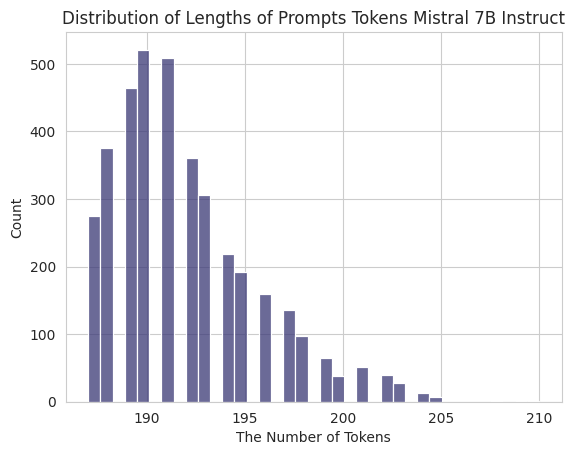

In [106]:
sns.histplot(data=data_quality_res, x='tokenized_prompt_APM4', color="#3A3875")

plt.title('Distribution of Lengths of Prompts Tokens Mistral 7B Instruct')
plt.xlabel("The Number of Tokens")
plt.show()


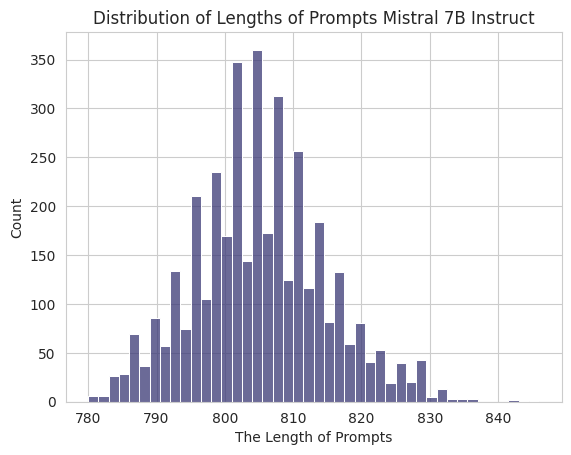

In [105]:
sns.histplot(data=data_quality_res, x='prompt_APM4', color="#3A3875")

plt.title('Distribution of Lengths of Prompts Mistral 7B Instruct')
plt.xlabel("The Length of Prompts")
plt.show()

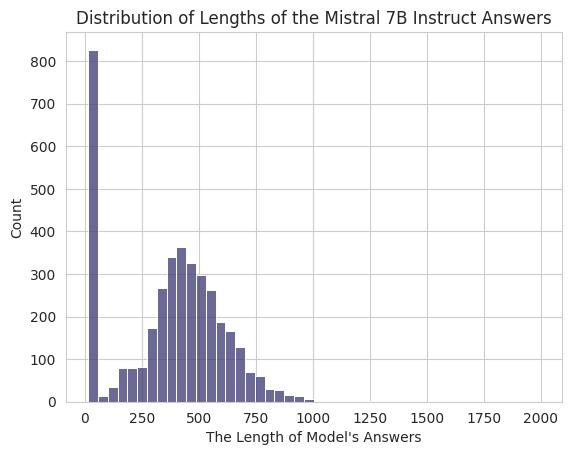

In [52]:
sns.histplot(data=data_quality_res, x='model_answer_APM4', color="#3A3875")

plt.title('Distribution of Lengths of the Mistral 7B Instruct Answers')
plt.xlabel("The Length of Model's Answers")
plt.show()

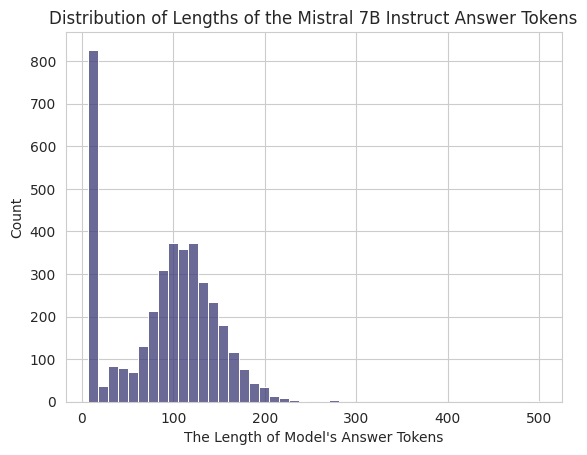

In [51]:
sns.histplot(data=data_quality_res, x='tokenized_model_answer_APM4', color="#3A3875")

plt.title('Distribution of Lengths of the Mistral 7B Instruct Answer Tokens')
plt.xlabel("The Length of Model's Answer Tokens")
plt.show()

In [53]:
data_quality_res["tokenized_model_answer_APM4"].describe()

count    3861.000000
mean       90.111629
std        55.562001
min         7.000000
25%        42.000000
50%       100.000000
75%       129.000000
max       500.000000
Name: tokenized_model_answer_APM4, dtype: float64

In [80]:
def find_substring_index(main_string, substring, return_substring=False):
    """Find the position of the substring (start, end)
    """
    m = substring.search(main_string)
    if not return_substring:
        try:
            return (m.start(), m.end())
        except:
            return (-1, -1)
    else:
        try:
            return m.group()
        except:
            return -1

In [74]:
main_string = "Answer: 1.</s>"
substring = re.compile("Answer: [0-9]*.")

index = find_substring_index(main_string, substring)
print(f"The index of the answer in the main string is: {index}")

10
The index of the answer in the main string is: 0


In [76]:
answer_start_id = []
answer_end_id = []
answer_str = re.compile("Answer: [0-9]*.")

for _, sample in tqdm(data_quality_res.iterrows()):
    answer_ids = find_substring_index(sample["model"], substring)
    answer_start_id.append(answer_ids[0])
    answer_end_id.append(answer_ids[1])

data_quality_res["answer_start_id_APM4"] = answer_start_id
data_quality_res["answer_end_id_APM4"] = answer_end_id

3861it [00:00, 8131.55it/s]


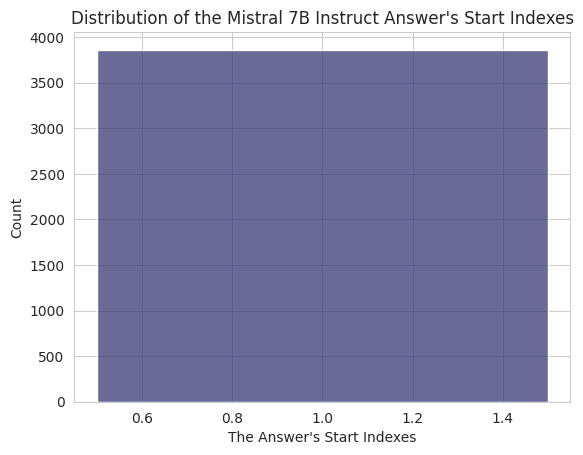

In [77]:
sns.histplot(data=data_quality_res, x='answer_start_id_APM4', color="#3A3875")

plt.title("Distribution of the Mistral 7B Instruct Answer's Start Indexes" )
plt.xlabel("The Answer's Start Indexes")
plt.show()

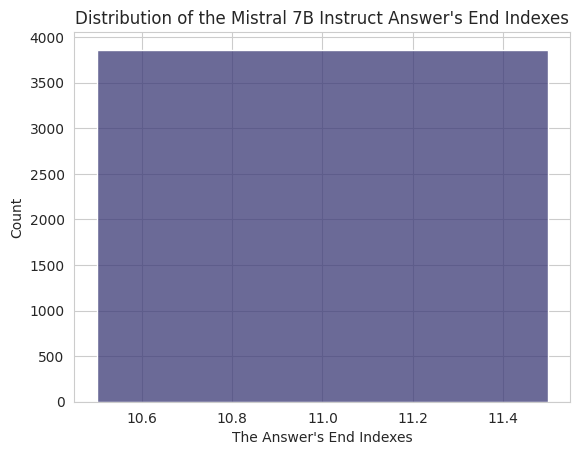

In [78]:
sns.histplot(data=data_quality_res, x='answer_end_id_APM4', color="#3A3875")

plt.title("Distribution of the Mistral 7B Instruct Answer's End Indexes" )
plt.xlabel("The Answer's End Indexes")
plt.show()

In [100]:
# Let's replace the classes represented by numbers with their analogues
# 0 - no
# 1 - rather no
# 2 - rather yes
# 3 - yes

answers_map = {
    0: "no",
    1: "rather no",
    2: "rather yes",
    3: "yes"
}

model_answer_letters = []
len_model_answer_tokenized = []
substring = re.compile("Answer: [0-9]*.")
for _, sample in tqdm(data_quality_res.iterrows()):
    # Extract substring
    answer = find_substring_index(sample["model"], substring, return_substring=True)
    result = []
    for word in answer:
        if word.isdigit():
            replacement = answers_map.get(int(word), word)
            result.append(replacement)
        else:
            result.append(word)
    answer = ''.join(result)

    model_answer_letters.append(answer)
    len_model_answer_tokenized.append(len(mistral_tokenizer(answer, return_tensors="pt", add_special_tokens=False)["input_ids"][0]))

3861it [00:01, 1953.51it/s]


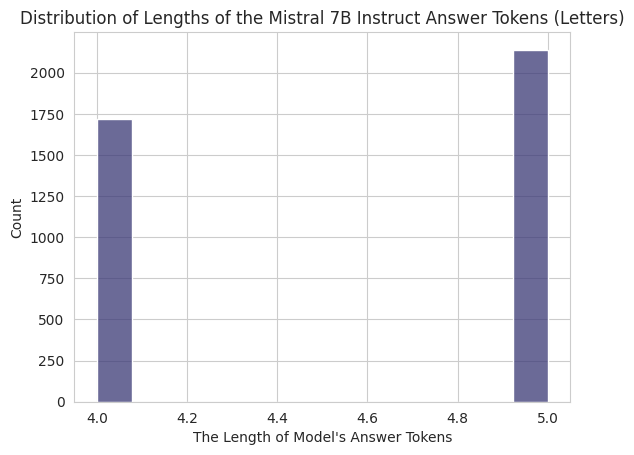

In [107]:
data_quality_res["tokenized_model_answer_letters_APM4"] = len_model_answer_tokenized
data_quality_res["model_answer_letters_APM4"] = model_answer_letters

sns.histplot(data=data_quality_res, x='tokenized_model_answer_letters_APM4', color="#3A3875")

plt.title('Distribution of Lengths of the Mistral 7B Instruct Answer Tokens (Letters)')
plt.xlabel("The Length of Model's Answer Tokens")
plt.show()

In [108]:
data_quality_res["tokenized_model_answer_letters_APM4"].describe()

count    3861.000000
mean        4.554261
std         0.497111
min         4.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: tokenized_model_answer_letters_APM4, dtype: float64

**Conclusion:** For further research, it is enough to generate 10 tokens (which corresponds to twice the length of the longest response)